https://blog.roboflow.com/train-a-custom-yolov8-pose-estimation-model/

https://www.youtube.com/watch?v=gA5N54IO1ko

In [1]:
!rm -rf ./runs # удаляем предыдущие результаты

!pip install ultralytics==8.0.196 # рекомендуемая стабильная версия
!pip install roboflow
!pip install torch

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


Чтобы запустить на сервере:
1. На сервере - `jupyter notebook`
2. На клиенте - `ssh -NfL localhost:ПОРТ:localhost:ПОРТ v.chekhovskii@84.237.51.129 -p 10023`
3. Открываем `localhost:ПОРТ` в браузере
4. Run -> Restart Kernel and Run All Cells... -> Restart

Чтобы остановить проброс портом:
1. На клиенте - `ssh -KL localhost:ПОРТ:localhost:ПОРТ v.chekhovskii@84.237.51.129 -p 10023`

# yolka_train.py

In [2]:
import ultralytics
from roboflow import Roboflow
from torch.utils.data import DataLoader

from IPython.display import Image, display
import os

Cкачиваем наш датасет с RoboFlow
(можно и хранить датасет локально, но так удобнее)

In [3]:
rf = Roboflow(api_key="IJmZ9Rj7mXzHlNQHLSSX")
project = rf.workspace("capjamesg").project("glue-keypoint-detection")
version = project.version(1)
dataset = version.download("yolov5")


loading Roboflow workspace...
loading Roboflow project...


Загружаем yolo-pose
(описание: https://github.com/ultralytics/ultralytics/issues/1915)

In [4]:
MODEL_NANE = 'yolov8m-pose'
#model = ultralytics.YOLO(f'{MODEL_NANE}.pt')
model = ultralytics.YOLO(f'./{MODEL_NANE}.pt')

Тренируем модель

In [5]:
EPOCHS = 100 # поменять на по болбше
DIR_TRAIN = f'{MODEL_NANE}_trained_{EPOCHS}'
DIR_PRED = f'{MODEL_NANE}_predicted_{EPOCHS}'

In [6]:
train = model.train(
    data=f'{dataset.location}/data.yaml',
    split='train',
    imgsz=640,
    epochs=EPOCHS,
    batch=16,
    name=DIR_TRAIN
)

New https://pypi.org/project/ultralytics/8.1.47 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.196 🚀 Python-3.10.12 torch-2.2.2+cu121 CUDA:0 (Tesla V100-SXM2-32GB, 32501MiB)
engine/trainer: task=pose, mode=train, model=./yolov8m-pose.pt, data=/home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/data.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolov8m-pose_trained_100, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=train, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid

~~Сохраняем веса~~
(вместо этого мы используем лучшие(!) веса за все эпохи
из "yolov8n_trained/weights/best.pt",
которые любезно за нас сохраняет YOLOv8)

In [7]:
#model.save('{MODEL_NANE}_trained')

Демонстрация результатов

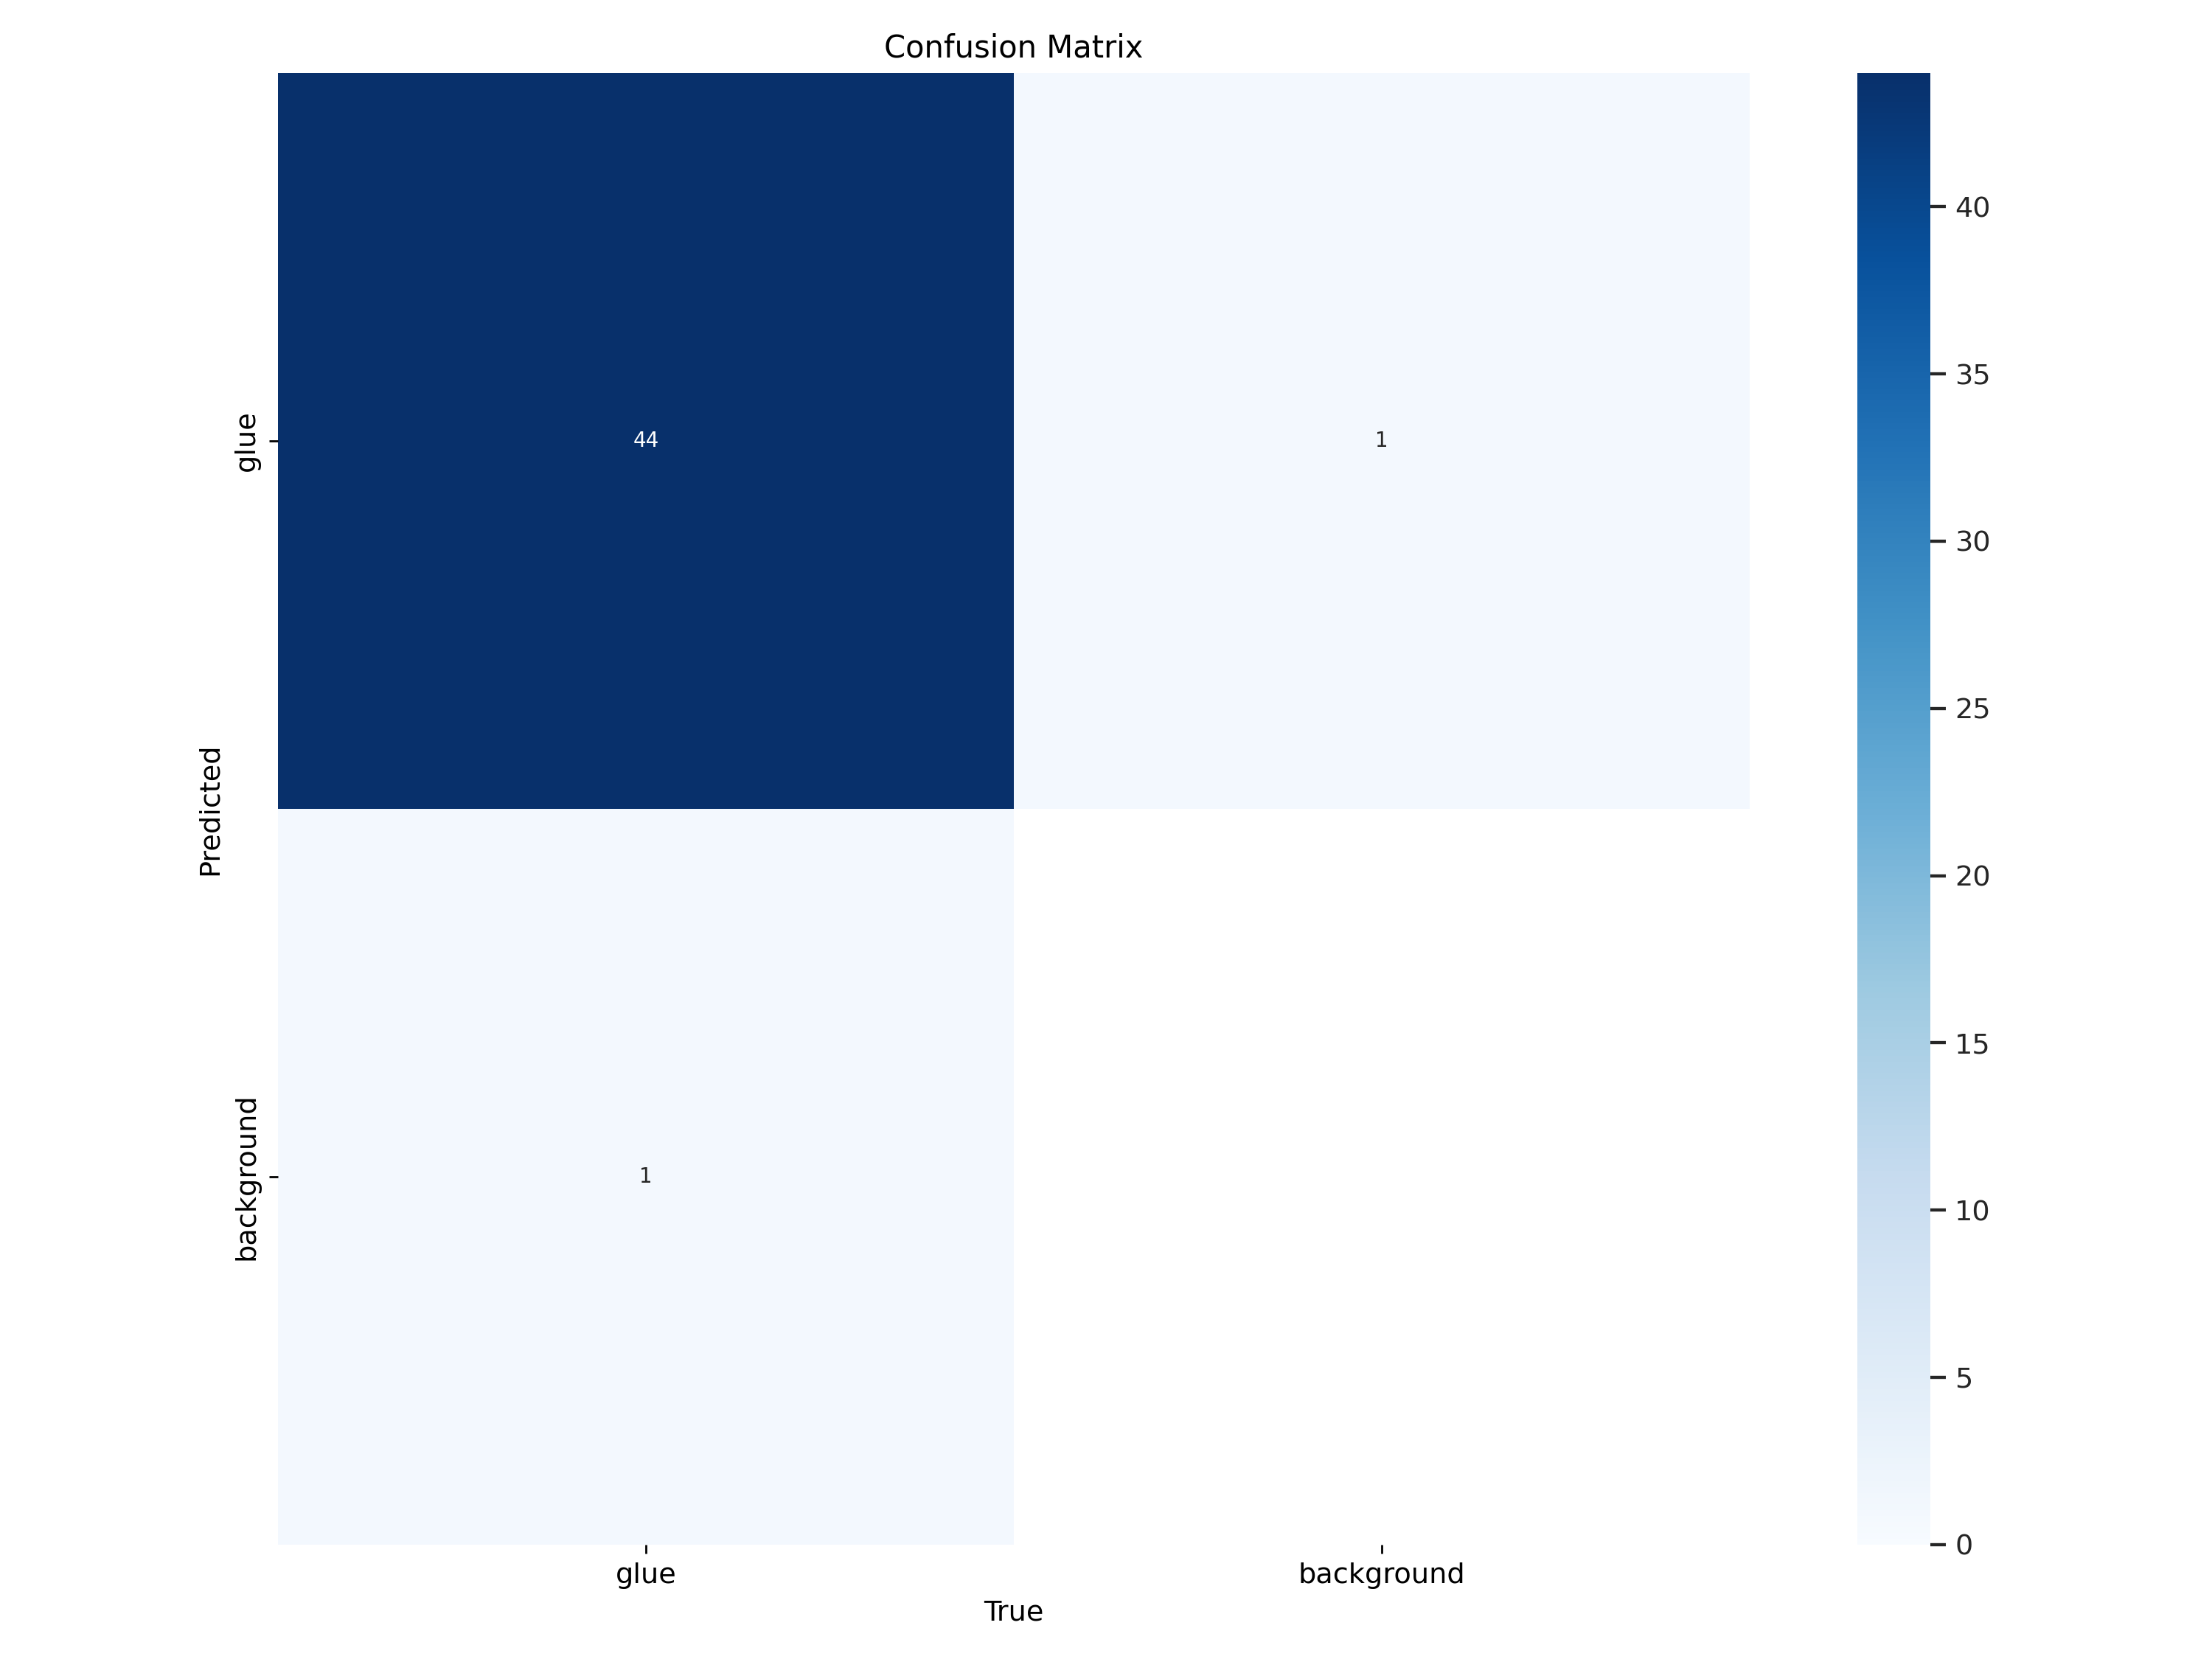

In [8]:
display(Image(f'./runs/pose/{DIR_TRAIN}/confusion_matrix.png', width=600))

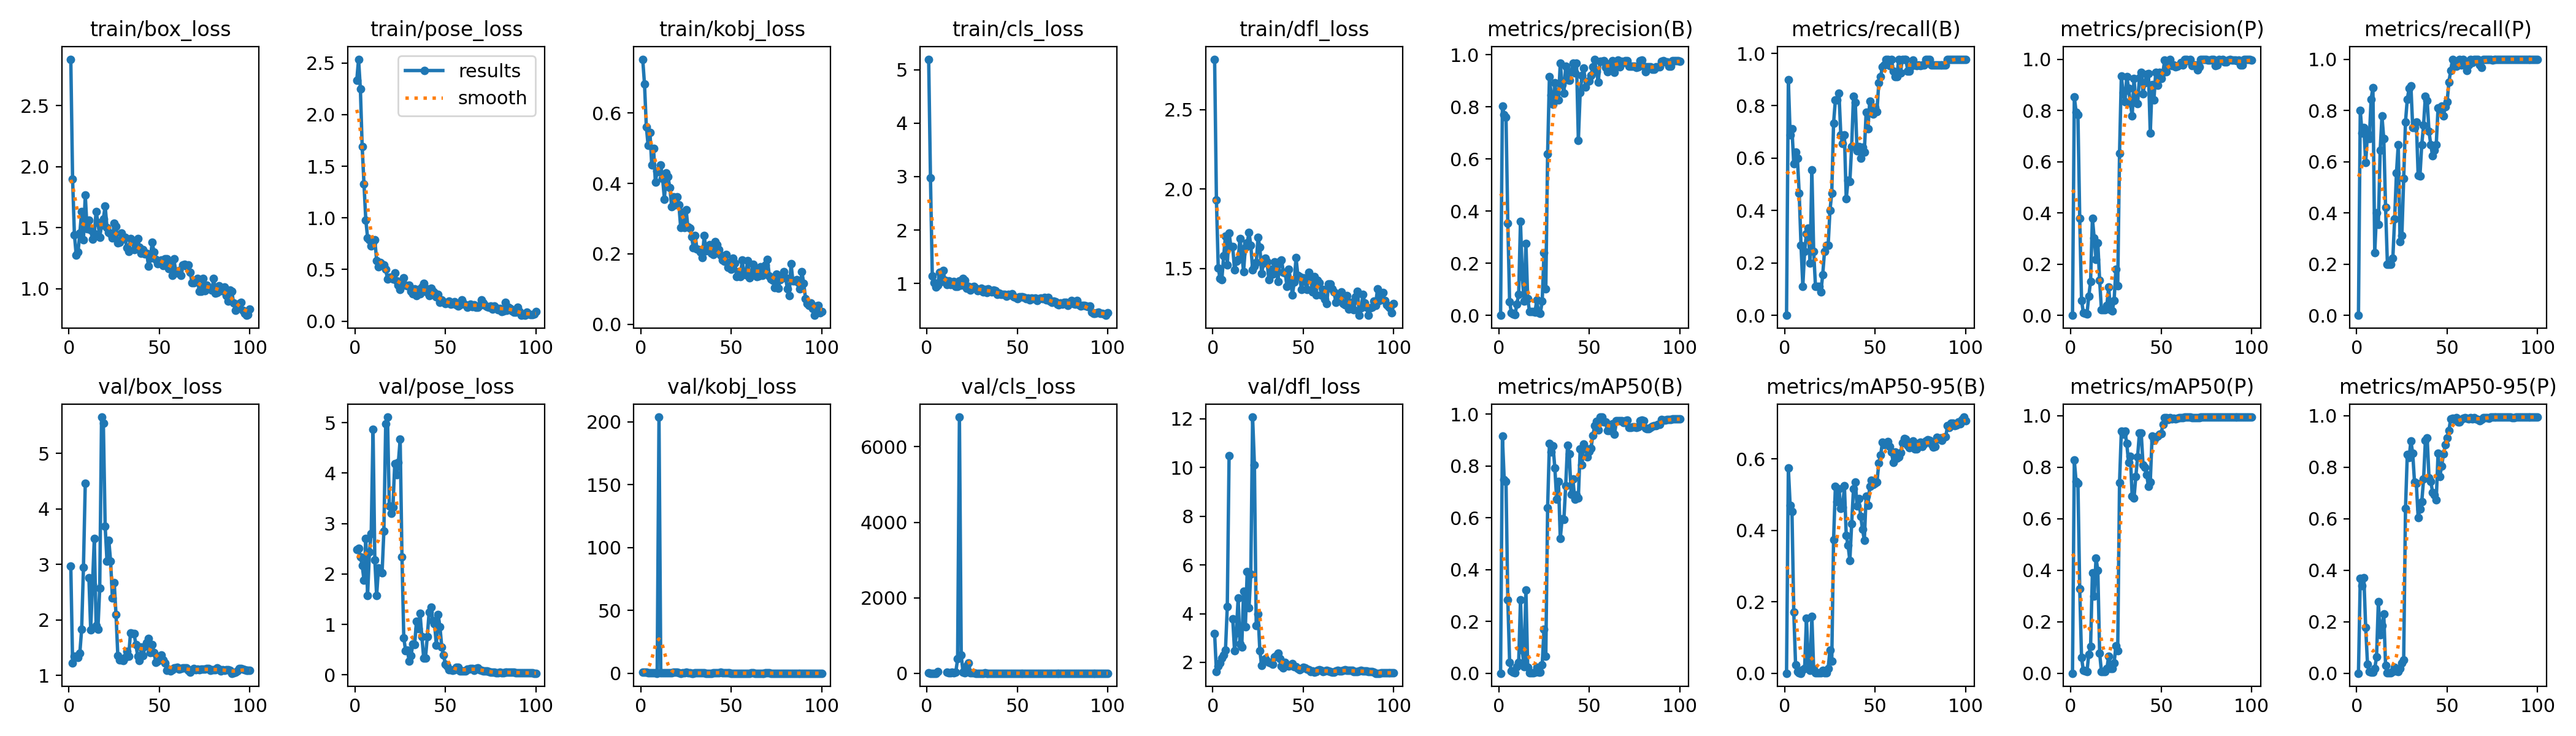

In [9]:
display(Image(f'./runs/pose/{DIR_TRAIN}/results.png', width=800))

# yolka_test.py

Загружаем новую модель с натренированными весами

In [10]:
#model = ultralytics.YOLO('{MODEL_NANE}_trained')
model = ultralytics.YOLO(f'./runs/pose/{DIR_TRAIN}/weights/best.pt')

Наконец, выполняем предсказания

In [11]:
pred = model.predict(
    source=f'{dataset.location}/test/images',
    conf=0.40, # 0.25, 0.40, 0.75...
    save=True,
    name=DIR_PRED
)


image 1/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4807_JPG.rf.ab0eaa1c6dc81f345bc7ec13049dcad9.jpg: 640x640 2 glues, 21.2ms
image 2/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4808_JPG.rf.5bd035b93837cd44d19c0373a352c4aa.jpg: 640x640 2 glues, 21.0ms
image 3/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4825_JPG.rf.7429ebe2dd73290c10f0b0a0ca648154.jpg: 640x640 2 glues, 21.3ms
image 4/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4837_JPG.rf.cdf9ddb4c0c4d5204b14ee6cac69121d.jpg: 640x640 2 glues, 21.2ms
image 5/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4849_JPG.rf.1b82becb0a79f8c6f0001934524cdc0e.jpg: 640x640 1 glue, 21.1ms
image 6/13 /home/v.chekhovskii/parallels_cuda/Glue-Keypoint-Detection-1/test/images/IMG_4852_JPG.rf.7cd777c66ad8ef339b6a72a66e7e9a75.jpg: 640x640 1 glue, 21.0ms
image 7/13 /home/v.chekhovski

Демонстрация результатов

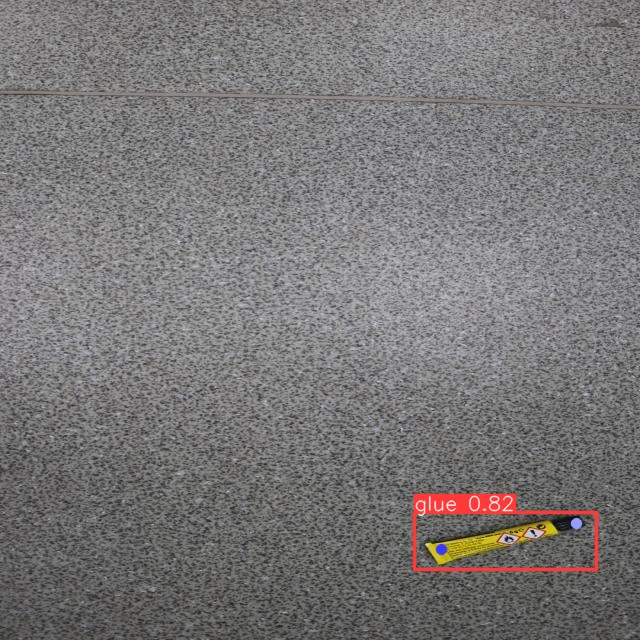

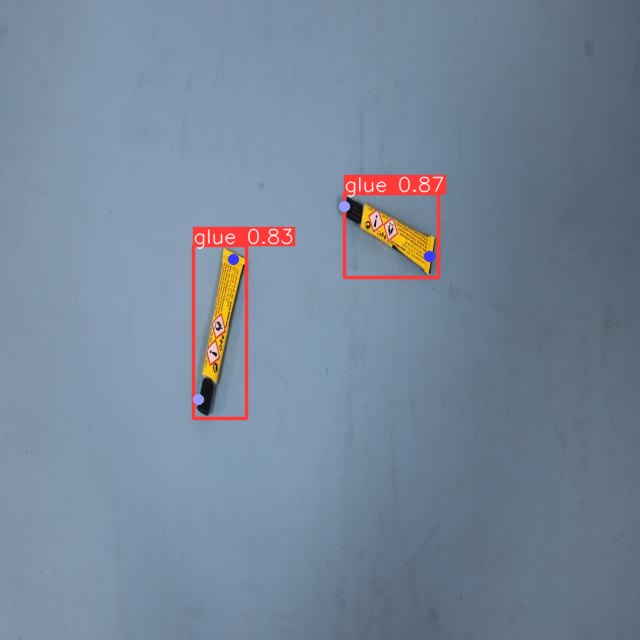

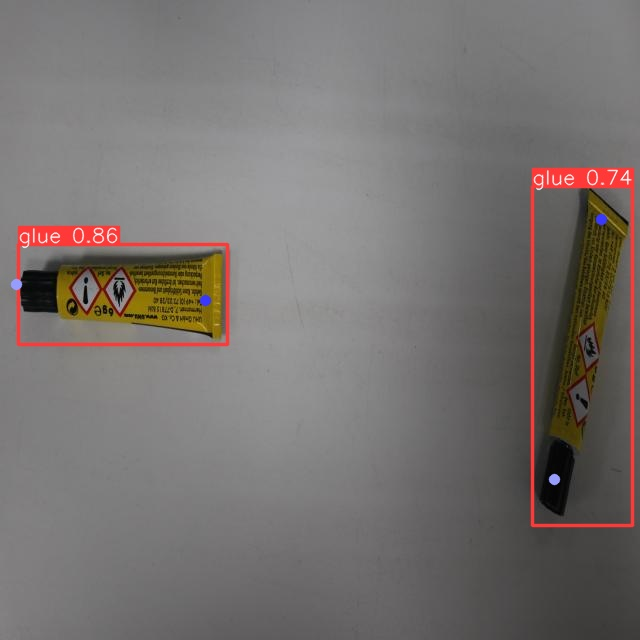

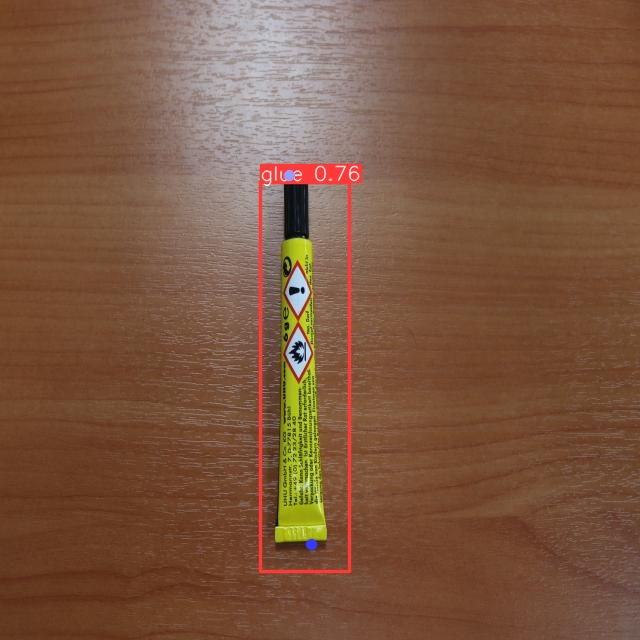

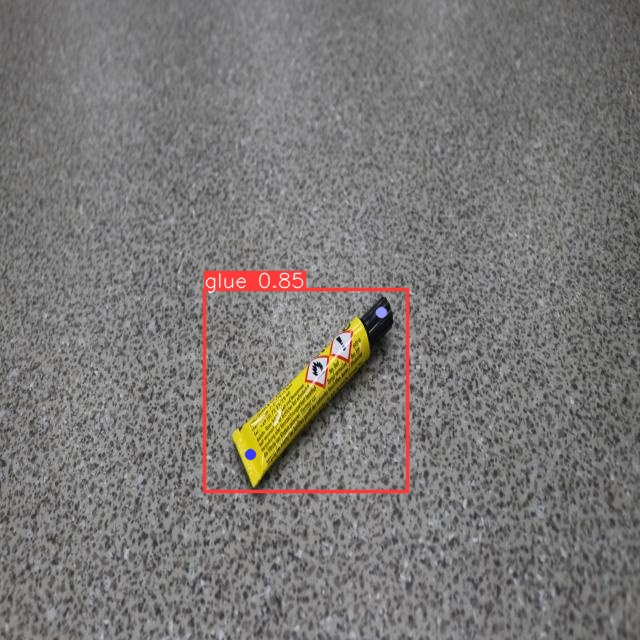

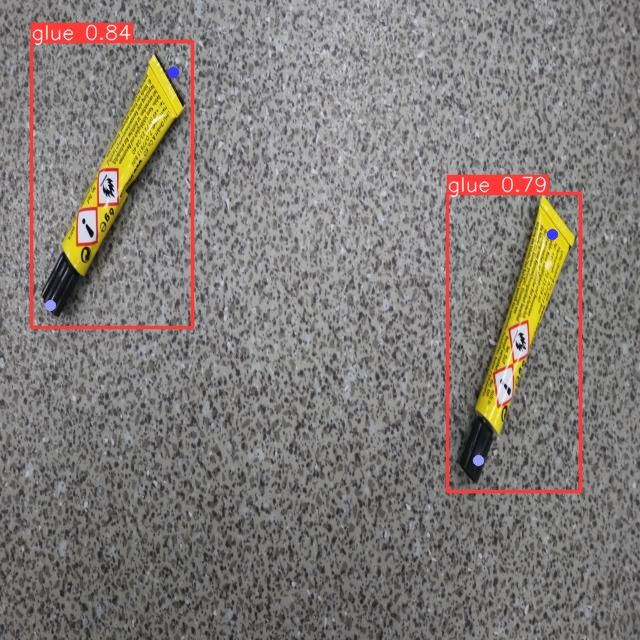

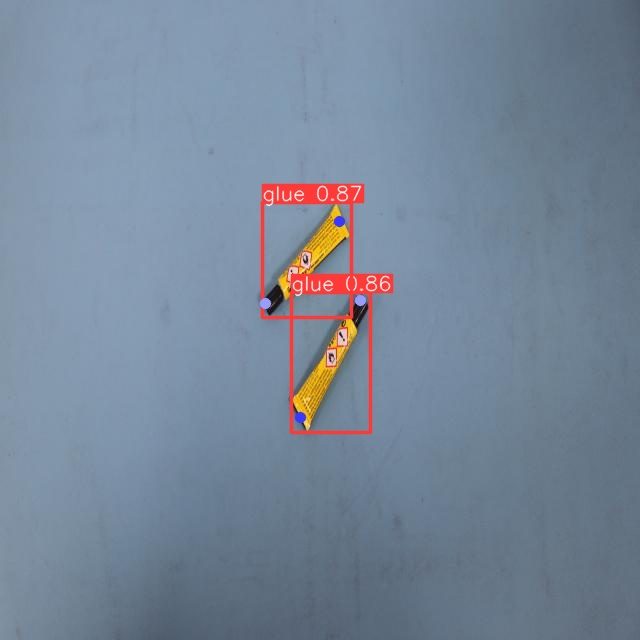

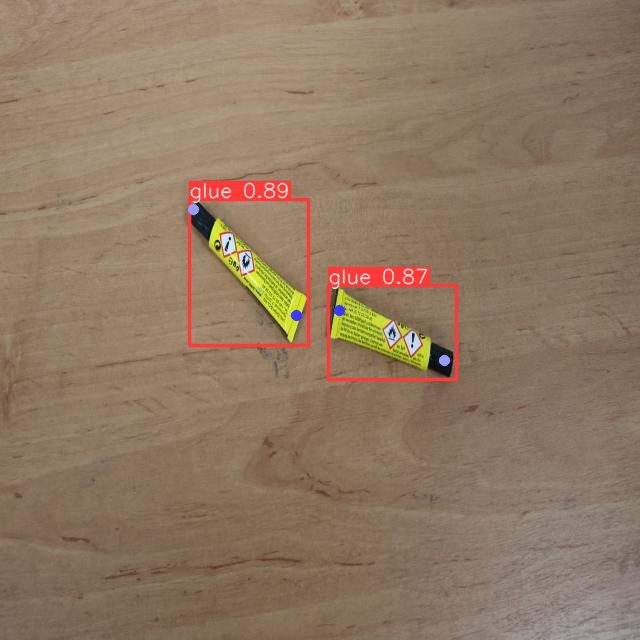

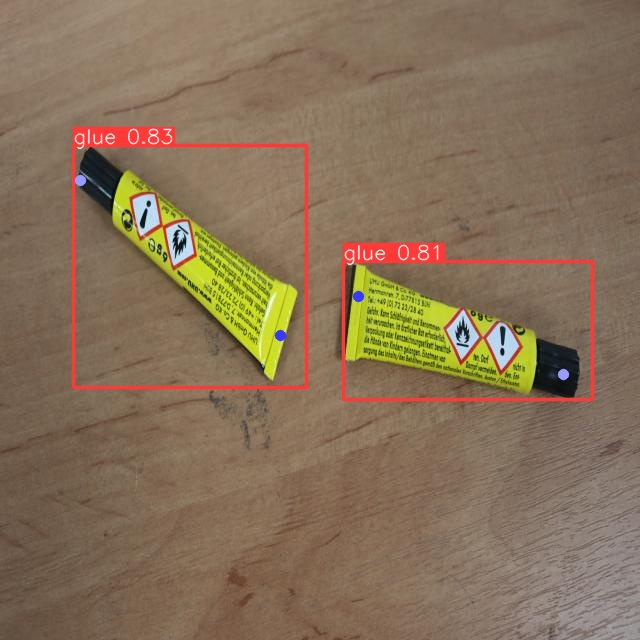

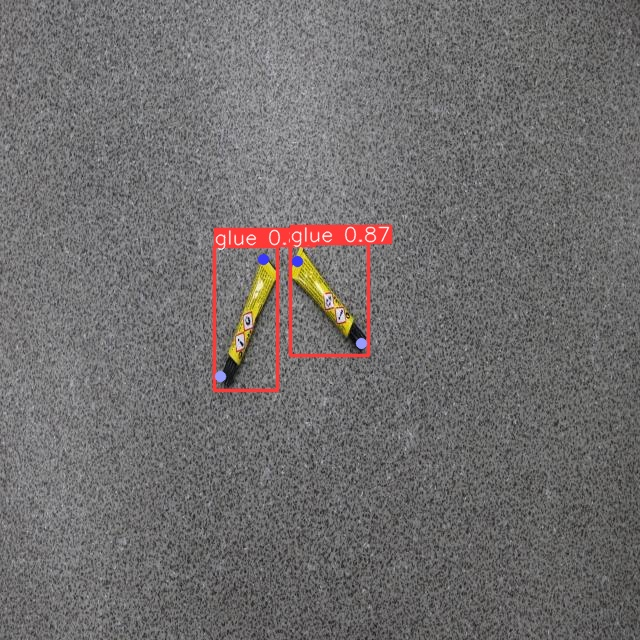

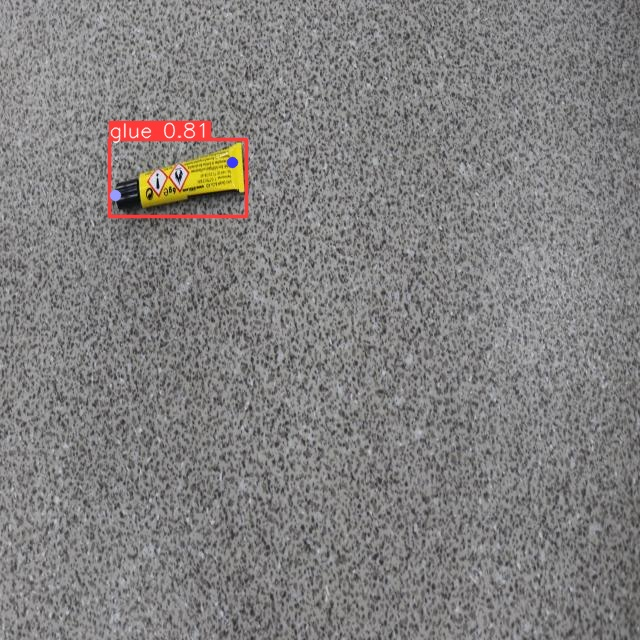

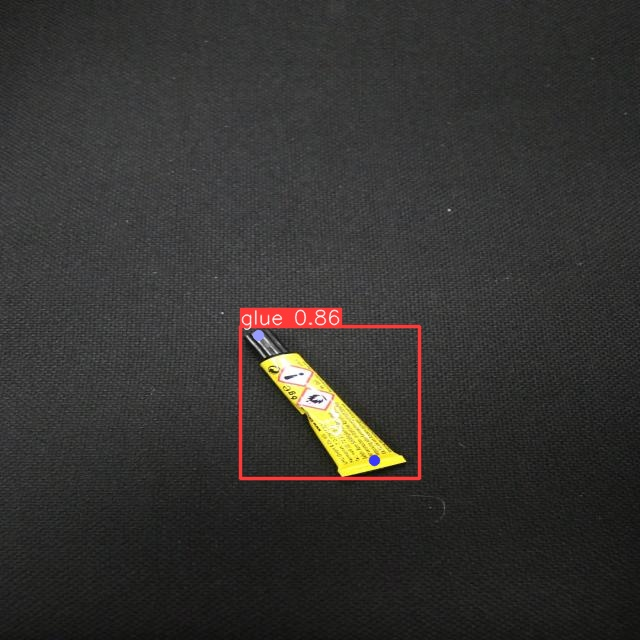

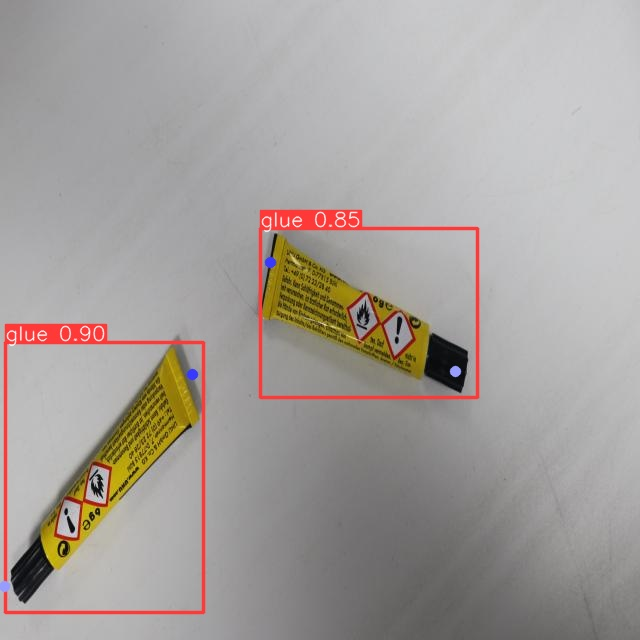

In [12]:
for imgname in os.listdir(f'./runs/pose/{DIR_PRED}'):
    display(Image(f'./runs/pose/{DIR_PRED}/{imgname}', width=200))